# NeuroGraph Dataset Exploration (Robust)

This notebook explores the NeuroGraph fMRI graph dataset via the `NeuroGraphDataModule` wrapper.

It will:
- Ensure imports work from this repo by adjusting `sys.path`
- Validate the dataset root: `/Users/balazsmorvay/Downloads`
- Load dataset with safe error handling and informative messages
- Compute basic stats and visualize distributions
- Render a sample graph if available


In [1]:
# Setup & Imports with robust path handling
import os
import sys
from pathlib import Path
from typing import Optional

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure repo root (containing `data/__init__.py`) is on sys.path
start_dir = Path.cwd()
repo_root = None
for _ in range(5):
    if (start_dir / 'data' / '__init__.py').exists():
        repo_root = str(start_dir)
        break
    start_dir = start_dir.parent
if repo_root and repo_root not in sys.path:
    sys.path.insert(0, repo_root)

try:
    from data import NeuroGraphDataModule
    from torch_geometric.utils import to_networkx
    import networkx as nx
except Exception as e:
    raise ImportError(
        f"Failed to import project modules or dependencies: {e}.\n"
        f"Checked repo_root={repo_root!r}. If None, run this notebook from the project or add its path to sys.path."
    )

sns.set(context="notebook", style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

DATA_ROOT = "/Users/balazsmorvay/Downloads"


In [2]:
# Validate data root and try to load dataset
from pprint import pprint

root_exists = os.path.exists(DATA_ROOT)
print(f"DATA_ROOT exists: {root_exists} -> {DATA_ROOT}")

load_ok = False
error_msg = None

dm = None
if root_exists:
    try:
        dm = NeuroGraphDataModule(root=DATA_ROOT, batch_size=16, num_workers=os.cpu_count() or 0, seed=42)
        dm.setup()
        # Access once to trigger lazy load
        _ = len(dm.dataset)
        load_ok = True
        print(f"Loaded dataset with {len(dm.dataset)} graphs.")
        print(f"Splits -> train: {len(dm.train_dataset)}, val: {len(dm.val_dataset)}, test: {len(dm.test_dataset)}")
        print("Domain counts:")
        pprint(dm.domain_counts())
    except Exception as e:
        error_msg = str(e)
        print("Failed to load dataset:", error_msg)
else:
    print("Data root does not exist. Please set DATA_ROOT correctly.")


DATA_ROOT exists: True -> /Users/balazsmorvay/Downloads


Extracting /Users/balazsmorvay/Downloads/HCPTask/raw/8wzz4y17wpxg2stip7iybtmymnybwvma.zip
Processing...
/Users/balazsmorvay/PycharmProjects/NeuroGraph/.venv/lib/python3.13/site-packages/torch_geometric/io/fs.py:229: UserWarning: Weights only load failed. Please file an issue to make `torch.load(weights_only=True)` compatible in your case. Please use `torch.serialization.add_safe_globals([torch_geometric.data.data.DataEdgeAttr])` to allowlist this global.
  warnings.warn(f"{warn_msg} Please use "
Done!


Loaded dataset with 7443 graphs.
Splits -> train: 5955, val: 744, test: 744
Domain counts:
{}


In [3]:
# Compute per-graph stats when available
import pandas as pd

if load_ok and len(dm.dataset) > 0:
    num_nodes = []
    num_edges = []
    labels = []
    domains = []

    for data in dm.dataset:
        num_nodes.append(int(data.num_nodes))
        num_edges.append(int(data.num_edges))

        y = getattr(data, 'y', None)
        if isinstance(y, torch.Tensor) and y.numel() > 0:
            labels.append(int(y.view(-1)[0].item()))
        else:
            labels.append(None)

        dval = None
        for key in ("domain", "site"):
            if hasattr(data, key):
                v = getattr(data, key)
                if isinstance(v, torch.Tensor) and v.numel() > 0:
                    dval = int(v.view(-1)[0].item())
                elif v is not None:
                    dval = v
                break
        domains.append(dval)

    stats_df = pd.DataFrame({
        'num_nodes': num_nodes,
        'num_edges': num_edges,
        'label': labels,
        'domain': domains,
    })
    display(stats_df.describe(include='all'))
else:
    print("Skipping stats: dataset not loaded.")


,num_nodes,num_edges,label,domain
count,7443.0,7443.000000,7443.000000,0
unique,NaN,NaN,NaN,0
top,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN
mean,400.0,7029.183931,3.006046,NaN
std,0.0,589.524729,2.001771,NaN
min,400.0,4764.000000,0.000000,NaN
25%,400.0,6628.000000,1.000000,NaN
50%,400.0,7106.000000,3.000000,NaN
75%,400.0,7502.000000,5.000000,NaN


/var/folders/z_/7fqm4zqs11zdv7cm41c6w_pc0000gn/T/ipykernel_17957/1821621590.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=stats_df['label'], ax=axes[1,0], palette='pastel')


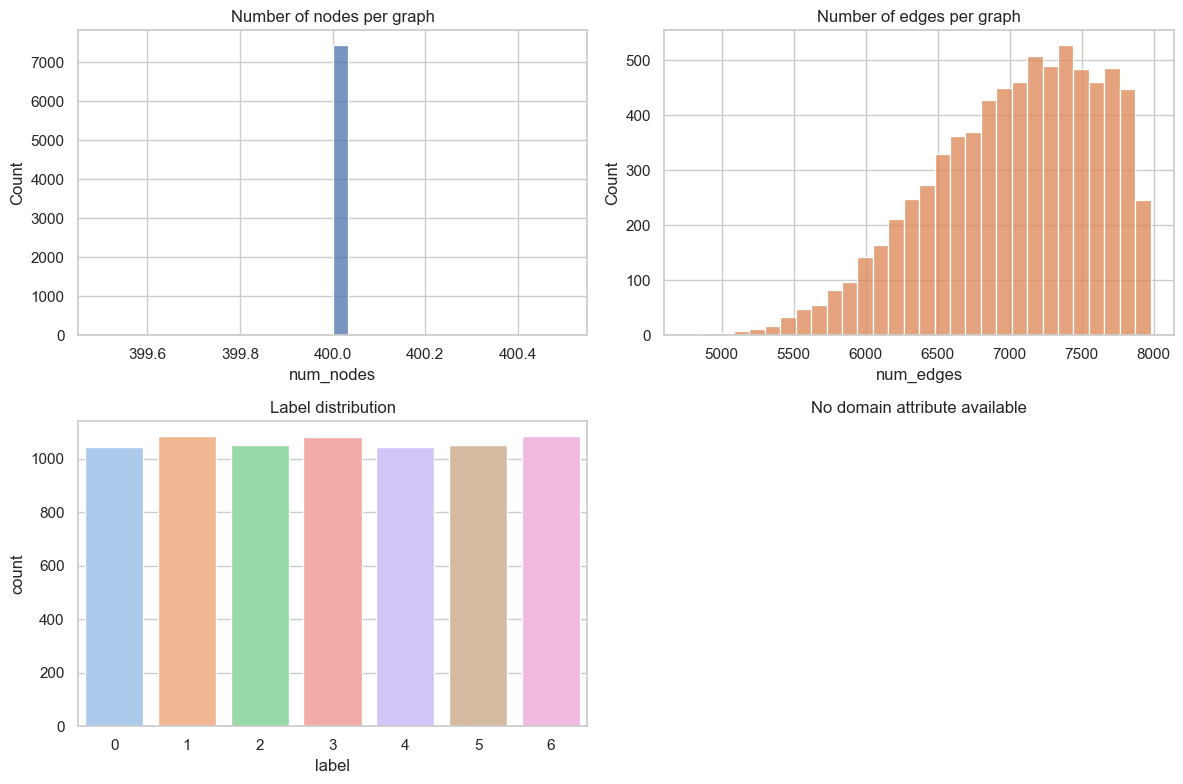

In [4]:
# Visualizations guarded by load_ok
if load_ok and len(dm.dataset) > 0:
    import seaborn as sns
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    sns.histplot(stats_df['num_nodes'], bins=30, ax=axes[0,0], color='C0')
    axes[0,0].set_title('Number of nodes per graph')

    sns.histplot(stats_df['num_edges'], bins=30, ax=axes[0,1], color='C1')
    axes[0,1].set_title('Number of edges per graph')

    if stats_df['label'].notna().any():
        sns.countplot(x=stats_df['label'], ax=axes[1,0], palette='pastel')
        axes[1,0].set_title('Label distribution')
    else:
        axes[1,0].axis('off')
        axes[1,0].set_title('No labels available')

    if stats_df['domain'].notna().any():
        sns.countplot(x=stats_df['domain'], ax=axes[1,1], palette='muted')
        axes[1,1].set_title('Domain/Site distribution')
    else:
        axes[1,1].axis('off')
        axes[1,1].set_title('No domain attribute available')

    plt.tight_layout()
    plt.show()
else:
    print("Skipping visualization: dataset not loaded.")


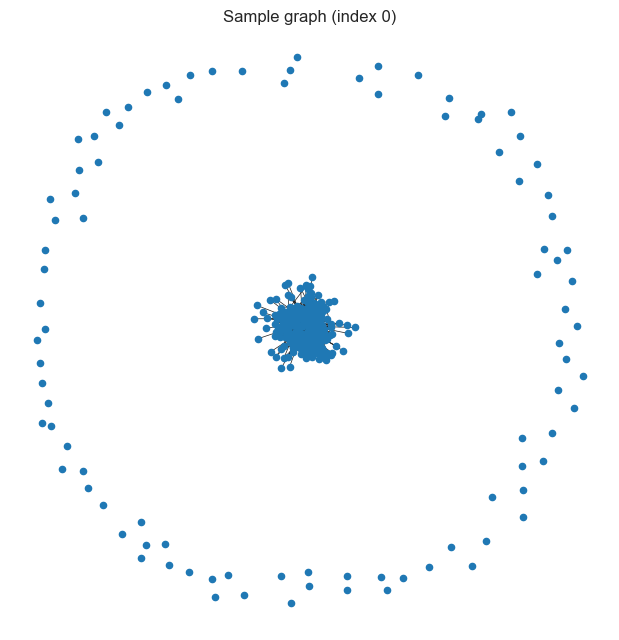

In [5]:
# Render a sample graph when available
if load_ok and len(dm.dataset) > 0:
    try:
        sample = dm.dataset[0]
        G = to_networkx(sample, to_undirected=True)

        import matplotlib.pyplot as plt
        import networkx as nx

        plt.figure(figsize=(6,6))
        pos = nx.spring_layout(G, seed=42)
        nx.draw(G, pos=pos, node_size=20, width=0.5)
        plt.title('Sample graph (index 0)')
        plt.show()
    except Exception as e:
        print("Failed to render sample graph:", e)
else:
    print("Skipping sample graph: dataset not loaded.")
